# Variability due to dynamical or property change?
redid equation to include cross term

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import pearsonr

## Functions

In [2]:
########
# MATH #
########

def decomp(data,base):
    # slight variation in euation from other attribution file
    # not dividing by transport - so looking at flux of a property instead of just mean property change
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'saltP':np.zeros(8),'saltQ':np.zeros(8),'saltX':np.zeros(8),'saltSUM':np.zeros(8),
        'tempP':np.zeros(8),'tempQ':np.zeros(8),'tempX':np.zeros(8),'tempSUM':np.zeros(8),
        'DOP':np.zeros(8),'DOQ':np.zeros(8),'DOX':np.zeros(8),'DOSUM':np.zeros(8),
        'TAP':np.zeros(8),'TAQ':np.zeros(8),'TAX':np.zeros(8),'TASUM':np.zeros(8),
        'NO3P':np.zeros(8),'NO3Q':np.zeros(8),'NO3X':np.zeros(8),'NO3SUM':np.zeros(8),
        'DICP':np.zeros(8),'DICQ':np.zeros(8),'DICX':np.zeros(8),'DICSUM':np.zeros(8)}
    df = pd.DataFrame(d)

    # salt
    df['saltP'] = (data.salt[1:] - base.salt[1:])*(base.transport[1:])
    df['saltQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.salt[1:]
    df['saltX'] = (data.salt[1:]-base.salt[1:])*(data.transport[1:]-base.transport[1:])
    df['saltSUM'] = df.saltP + df.saltQ

    # temp
    df['tempP'] = (data.temp[1:] - base.temp[1:])*(base.transport[1:])
    df['tempQ'] = ((data.transport[1:])  - (base.transport[1:]))*base.temp[1:]
    df['tempX'] = (data.temp[1:]-base.temp[1:])*(data.transport[1:]-base.transport[1:])
    df['tempSUM'] = df.tempP + df.tempQ

    # do
    df['DOP'] = (data.DO[1:] - base.DO[1:])*(base.transport[1:])
    df['DOQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.DO[1:]
    df['DOX'] = (data.DO[1:]-base.DO[1:])*(data.transport[1:]-base.transport[1:])
    df['DOSUM'] = df.DOP + df.DOQ

    # ta
    df['TAP'] = (data.TA[1:] - base.TA[1:])*(base.transport[1:])
    df['TAQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.TA[1:]
    df['TAX'] = (data.TA[1:]-base.TA[1:])*(data.transport[1:]-base.transport[1:])
    df['TASUM'] = df.TAP + df.TAQ

    # dic
    df['DICP'] = (data.DIC[1:] - base.DIC[1:])*(base.transport[1:])
    df['DICQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.DIC[1:]
    df['DICX'] = (data.DIC[1:]-base.DIC[1:])*(data.transport[1:]-base.transport[1:])
    df['DICSUM'] = df.DICP + df.DICQ

    # no3
    df['NO3P'] = (data.NO3[1:] - base.NO3[1:])*(base.transport[1:])
    df['NO3Q'] = ((data.transport[1:]) - (base.transport[1:]))*base.NO3[1:]
    df['NO3X'] = (data.NO3[1:]-base.NO3[1:])*(data.transport[1:]-base.transport[1:])
    df['NO3SUM'] = df.NO3P + df.NO3Q

    # TA-DIC
    df['TADICP'] = (data['TA-DIC'][1:] - base['TA-DIC'][1:])*(base.transport[1:])
    df['TADICQ'] = ((data.transport[1:]) - (base.transport[1:]))*base['TA-DIC'][1:]
    df['TADICX'] = (data['TA-DIC'][1:]-base['TA-DIC'][1:])*(data.transport[1:]-base.transport[1:])
    df['TADICSUM'] = df.TADICP + df.TADICQ

    # TA:DIC
    if 'TA:DIC' in data.columns:
        df['TA:DICP'] = (data['TA:DIC'][1:] - base['TA:DIC'][1:])*(base.transport[1:])
        df['TA:DICQ'] = ((data.transport[1:]) - (base.transport[1:]))*base['TA:DIC'][1:]
        df['TA:DICX'] = (data['TA:DIC'][1:]-base['TA:DIC'][1:])*(data.transport[1:]-base.transport[1:])
        df['TA:DICSUM'] = df['TA:DICP'] + df['TA:DICQ']

    return df
    

In [3]:
############
# PLOTTING #
############

def three_bar(df, property,ax):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()
    df['absX'] = df[df.columns[4]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ', 'absX']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']
    df['normX'] = df['absX'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ', 'normX']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)
    pivotX = agg_df.pivot(index='year', columns='section', values='normX').fillna(0)

    colors = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
    sections = ['cuc','off_d','off_s','north','south','fresh']
    # for i, section in enumerate(pivotP.columns):
    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotQ.index-0.3, pivotQ[section], bottom=cum_values, color=colors[i % len(colors)], edgecolor=colors[i % len(colors)], hatch='///', alpha=0.8, width=0.29, label=section)
            cum_values += pivotQ[section]

    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotP.index, pivotP[section], bottom=cum_values, color=colors[i % len(colors)], width=0.29, label=section)
            cum_values += pivotP[section]

    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotX.index+0.3, pivotX[section], bottom=cum_values, color=colors[i % len(colors)], alpha=0.6, width=0.29, label=section)
            cum_values += pivotX[section]

    # Customize plot
    ax.set_title(property)
    ax.set_xlim([np.min(pivotQ.index)-1,np.max(pivotQ.index)+1])
    ax.set_xticks(pivotQ.index)
    ax.set_yticks([0,0.5,1])
    ax.set_xticklabels([])
    ax.set_ylim([0,1])

def combined_stacked_bar(df, property, ax, ax2):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['darkviolet','magenta', 'mediumseagreen','midnightblue','deepskyblue','red']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax.set_yticklabels(list(set(df.year)),fontsize=8)

    
    if str(type(ax2)) == "<class 'matplotlib.axes._axes.Axes'>":
        # Ensure both axes share the same y-axis
        ax2.sharey(ax)
        # Hide y-tick labels on ax2
        ax2.tick_params(axis='y', which='both', labelleft=False)

    plt.tight_layout()

def combined_stacked_bar_LOOP(df, property, ax, ax2):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> loop -> north -> off_d -> off_s -> south
    colors = ['darkviolet','magenta', 'grey', 'mediumseagreen','midnightblue','deepskyblue','red']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax.set_yticklabels(list(set(df.year)),fontsize=8)

    
    if str(type(ax2)) == "<class 'matplotlib.axes._axes.Axes'>":
        # Ensure both axes share the same y-axis
        ax2.sharey(ax)
        # Hide y-tick labels on ax2
        ax2.tick_params(axis='y', which='both', labelleft=False)

    plt.tight_layout()

## Volume and property corelation 

In [4]:
all14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2014.csv')
all15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2015.csv')
all16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2016.csv')
all17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2017.csv')
all18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2018.csv')
all19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2019.csv')
all20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2020.csv')
all21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2021.csv')
all22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2022.csv')
all23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2023.csv')

In [5]:
d = {'2014':all14.transport[1:],'2015':all15.transport[1:],
     '2016':all16.transport[1:],'2017':all17.transport[1:],'2018':all18.transport[1:],
     '2019':all19.transport[1:],'2020':all20.transport[1:],'2021':all21.transport[1:],
     '2022':all22.transport[1:],'2023':all23.transport[1:]}
all = pd.DataFrame(d)

regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh', 'Loop']

In [6]:
# add TA:DIC column

all14['TA:DIC'] = all14.TA/all14.DIC
all15['TA:DIC'] = all15.TA/all15.DIC
all16['TA:DIC'] = all16.TA/all16.DIC
all17['TA:DIC'] = all17.TA/all17.DIC
all18['TA:DIC'] = all18.TA/all18.DIC
all19['TA:DIC'] = all19.TA/all19.DIC
all20['TA:DIC'] = all20.TA/all20.DIC
all21['TA:DIC'] = all21.TA/all21.DIC
all22['TA:DIC'] = all22.TA/all22.DIC
all23['TA:DIC'] = all23.TA/all23.DIC

In [7]:
# annual mean properties into JdF
# transport weighted means of the inflowing properties
salt = [all14.salt[0],all15.salt[0],
     all16.salt[0],all17.salt[0],
     all18.salt[0],all19.salt[0],
     all20.salt[0],all21.salt[0],
     all22.salt[0],all23.salt[0]]

temp = [all14.temp[0],all15.temp[0],
     all16.temp[0],all17.temp[0],
     all18.temp[0],
     all19.temp[0],all20.temp[0],
     all21.temp[0],all22.temp[0],
     all23.temp[0]]

DO = [all14.DO[0],all15.DO[0],
     all16.DO[0],all17.DO[0],
     all18.DO[0],
     all19.DO[0],all20.DO[0],
     all21.DO[0],all22.DO[0],
     all23.DO[0]]

NO3 = [all14.NO3[0],all15.NO3[0],
     all16.NO3[0],all17.NO3[0],
     all18.NO3[0],
     all19.NO3[0],all20.NO3[0],
     all21.NO3[0],all22.NO3[0],
     all23.NO3[0]]

TADIC = [all14['[TA-DIC]'][0],all15['[TA-DIC]'][0],
     all16['[TA-DIC]'][0],all17['[TA-DIC]'][0],
     all18['[TA-DIC]'][0],
     all19['[TA-DIC]'][0],all20['[TA-DIC]'][0],
     all21['[TA-DIC]'][0],all22['[TA-DIC]'][0],
     all23['[TA-DIC]'][0]]

TADICratio = [all14['TA:DIC'][0],all15['TA:DIC'][0],
     all16['TA:DIC'][0],all17['TA:DIC'][0],
     all18['TA:DIC'][0],
     all19['TA:DIC'][0],all20['TA:DIC'][0],
     all21['TA:DIC'][0],all22['TA:DIC'][0],
     all23['TA:DIC'][0]]

In [8]:
all['section'] = ['cuc','offd','offs','north','south','fresh','loop']

In [9]:
all = all.reindex([1,2,3,5,4,6,7])
all

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,section
1,2.462073e+08,2.464463e+08,2.231439e+08,3.086597e+08,3.027574e+08,2.470653e+08,2.976967e+08,2.951705e+08,3.676508e+08,2.923004e+08,cuc
2,1.975970e+08,2.592791e+08,2.491655e+08,1.760029e+08,1.991930e+08,2.586149e+08,2.462440e+08,1.908299e+08,1.631523e+08,1.553563e+08,offd
3,5.155185e+07,1.100921e+08,6.128392e+07,5.998644e+07,5.533254e+07,4.366710e+07,6.613465e+07,3.755567e+07,8.878156e+07,3.926016e+07,offs
5,1.273339e+08,2.446863e+08,2.106232e+08,2.301166e+08,1.670901e+08,2.114636e+08,1.037570e+08,1.539312e+08,1.954030e+08,1.927002e+08,south
4,1.410987e+08,1.607634e+08,1.324742e+08,1.683593e+08,1.727569e+08,2.081716e+08,1.557370e+08,1.650328e+08,1.350801e+08,1.158886e+08,north
6,9.877364e+07,1.077782e+08,9.401023e+07,1.149861e+08,9.222280e+07,7.507590e+07,6.216470e+07,6.385509e+07,8.427596e+07,8.527073e+07,fresh
7,3.607165e+08,4.646745e+08,4.182435e+08,4.863923e+08,4.066038e+08,4.770674e+08,3.894157e+08,4.280312e+08,4.813814e+08,4.243668e+08,loop


In [10]:
# bring in upwelling and downwelling information
# up13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv')
up19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2019.csv')
up20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2020.csv')
up21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv')
up23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2023.csv')

dw13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv')
dw14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2015.csv')
dw15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv')
dw18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2019.csv')
dw19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv')
dw22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2023.csv')

lup = np.array([161, 144, 158, 156,128,193, 244,189, 117,136])
ldw = np.array([113, 143, 149, 198, 91, 163, 53, 82, 105,176])

d = {'2014':up14.transport[1:]*lup[0],'2015':up15.transport[1:]*lup[1],
     '2016':up16.transport[1:]*lup[2],'2017':up17.transport[1:]*lup[3],'2018':up18.transport[1:]*lup[4],
     '2019':up19.transport[1:]*lup[5],'2020':up20.transport[1:]*lup[6],'2021':up21.transport[1:]*lup[7],
     '2022':up22.transport[1:]*lup[8],'2023':up23.transport[1:]*lup[9]}
up = pd.DataFrame(d)

d = {'2014':dw13.transport[1:]*ldw[0],'2015':dw14.transport[1:]*ldw[1],'2016':dw15.transport[1:]*ldw[2],
     '2017':dw16.transport[1:]*ldw[3],'2018':dw17.transport[1:]*ldw[4],'2019':dw18.transport[1:]*ldw[4],
     '2020':dw19.transport[1:]*ldw[6],'2021':dw20.transport[1:]*ldw[7],'2022':dw21.transport[1:]*ldw[8],
     '2023':dw22.transport[1:]*ldw[9]}
dw = pd.DataFrame(d)




Text(0.03, 0.95, 'g)')

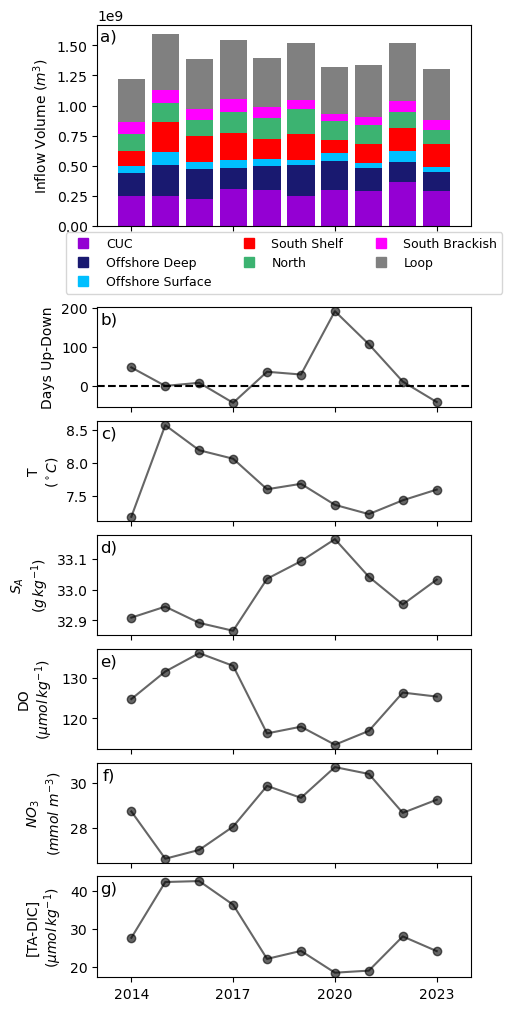

In [11]:
## Interannual variability in watermass inflow with average properties
# with loop flow
# Assign colors to each section
colors = ['darkviolet','midnightblue','deepskyblue','red','mediumseagreen','magenta','grey']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,10])
gs = GridSpec(8, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3,0]) # temp
ax5 = fig.add_subplot(gs[4,0]) # salt
ax6 = fig.add_subplot(gs[5,0]) # DO
ax7 = fig.add_subplot(gs[6,0]) # NO3
ax8 = fig.add_subplot(gs[7,0]) # TA-DIC   

# Plot all 
all_cum_values = np.zeros(len(all.columns[:-1]))
for i in range(len(all)):
    bars = ax1.bar(pd.to_numeric((all.columns[:-1])), all.iloc[i,:-1], bottom=all_cum_values, color=colors[i % len(colors)])
    all_cum_values += all.iloc[i,:-1]
ax1.text(.03, 0.98, 'a)', ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_ylabel('Inflow Volume ($m^3$)')


# Customize plot
for axs in [ax1,ax3,ax4,ax5,ax6,ax7,ax8]:
    axs.set_xlim([2013,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1,ax3,ax4,ax5,ax6,ax7]:
    axs.set_xticklabels([])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'South Shelf', 'North', 'South Brackish','Loop']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colors[i], markerfacecolor=colors[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

# season ratio
ax3.plot(np.arange(2014,2024,1),lup-ldw, alpha=0.6,c='k',marker='o')
ax3.set_ylabel('Days Up-Down',fontsize=10)
ax3.plot([2013,2024],[0,0],'k--')
ax3.text(.03, 0.95, 'b)', ha='center', va='top', transform=ax3.transAxes, fontsize=12)

# temperature
ax4.plot(np.arange(2014,2024,1),temp, alpha=0.6,c='k',marker='o')
ax4.set_ylabel('T\n($^\circ C$)',fontsize=10)
# ax4.plot([2013,2024],[0,0],'k--')
ax4.text(.03, 0.95, 'c)', ha='center', va='top', transform=ax4.transAxes, fontsize=12)

#salt
ax5.plot(np.arange(2014,2024,1),salt, alpha=0.6,c='k',marker='o')
ax5.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10)
# ax5.plot([2013,2024],[0,0],'k--')
ax5.text(.03, 0.95, 'd)', ha='center', va='top', transform=ax5.transAxes, fontsize=12)

# DO
ax6.plot(np.arange(2014,2024,1),DO, alpha=0.6,c='k',marker='o')
ax6.set_ylabel('DO\n($\mu mol \, kg^{-1}$)',fontsize=10)
# ax6.plot([2013,2024],[0,0],'k--')
ax6.text(.03, 0.95, 'e)', ha='center', va='top', transform=ax6.transAxes, fontsize=12)

# NO3
ax7.plot(np.arange(2014,2024,1),NO3, alpha=0.6,c='k',marker='o')
ax7.set_ylabel('$NO_3$\n($mmol\,\,m^{-3}$)',fontsize=10)
# ax7.plot([2013,2024],[0,0],'k--')
ax7.text(.03, 0.95, 'f)', ha='center', va='top', transform=ax7.transAxes, fontsize=12)

# TA-DIC
ax8.plot(np.arange(2014,2024,1),TADIC, alpha=0.6,c='k',marker='o')
ax8.set_ylabel('[TA-DIC]\n($\mu mol \, kg^{-1}$)',fontsize=10)
# ax8.plot([2013,2024],[0,0],'k--')
ax8.text(.03, 0.95, 'g)', ha='center', va='top', transform=ax8.transAxes, fontsize=12)

# plt.savefig('/data1/bbeutel/LO_user/ariane/figures/volumebar_loop.jpg')


Text(0, 0.5, 'TA:DIC')

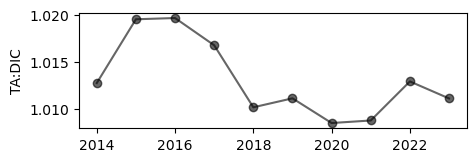

In [12]:
fig,ax = plt.subplots(1,1,figsize=[5,1.5])
ax.plot(np.arange(2014,2024,1),TADICratio, alpha=0.6,c='k',marker='o')
ax.set_ylabel('TA:DIC',fontsize=10)

Text(0.03, 0.95, 'g)')

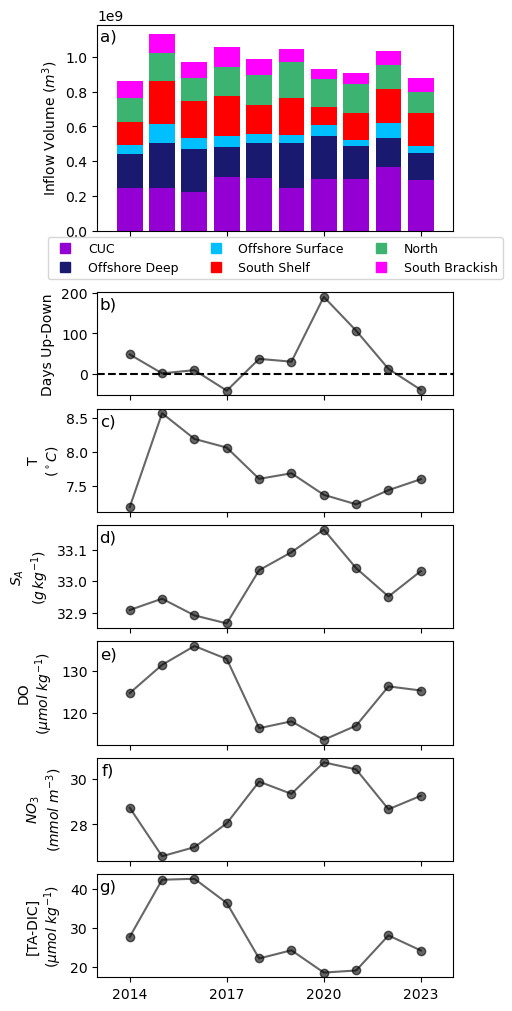

In [13]:
## Interannual varriability in watermass inflow with average properties
# without loop flow
# Assign colors to each section
colors = ['darkviolet','midnightblue','deepskyblue','red','mediumseagreen','magenta','grey']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,10])
gs = GridSpec(8, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3,0]) # temp
ax5 = fig.add_subplot(gs[4,0]) # salt
ax6 = fig.add_subplot(gs[5,0]) # DO
ax7 = fig.add_subplot(gs[6,0]) # NO3
ax8 = fig.add_subplot(gs[7,0]) # TA-DIC   

# Plot all 
allX = all[all.section!='loop']
all_cum_values = np.zeros(len(allX.columns[:-1]))
for i in range(len(allX)):
    bars = ax1.bar(pd.to_numeric((allX.columns[:-1])), allX.iloc[i,:-1], bottom=all_cum_values, color=colors[i % len(colors)])
    all_cum_values += allX.iloc[i,:-1]
ax1.text(.03, 0.98, 'a)', ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_ylabel('Inflow Volume ($m^3$)')


# Customize plot
# axs.set_ylim(0,360000000000)
# axs.set_yticks([0,50000,150000])
# axs.set_yticklabels([0,50,150])
axs.set_ylabel('Inflow Volume [$m^3$]')
for axs in [ax1,ax3,ax4,ax5,ax6,ax7,ax8]:
    axs.set_xlim([2013,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1,ax3,ax4,ax5,ax6,ax7]:
    axs.set_xticklabels([])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'South Shelf', 'North', 'South Brackish']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colors[i], markerfacecolor=colors[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

# season ratio
ax3.plot(np.arange(2014,2024,1),lup-ldw, alpha=0.6,c='k',marker='o')
ax3.set_ylabel('Days Up-Down',fontsize=10)
ax3.plot([2013,2024],[0,0],'k--')
ax3.text(.03, 0.95, 'b)', ha='center', va='top', transform=ax3.transAxes, fontsize=12)

# temperature
ax4.plot(np.arange(2014,2024,1),temp, alpha=0.6,c='k',marker='o')
ax4.set_ylabel('T\n($^\circ C$)',fontsize=10)
# ax4.plot([2013,2024],[0,0],'k--')
ax4.text(.03, 0.95, 'c)', ha='center', va='top', transform=ax4.transAxes, fontsize=12)

#salt
ax5.plot(np.arange(2014,2024,1),salt, alpha=0.6,c='k',marker='o')
ax5.set_ylabel('$S_A$\n$(g\,kg^{-1}$)',fontsize=10)
# ax5.plot([2013,2024],[0,0],'k--')
ax5.text(.03, 0.95, 'd)', ha='center', va='top', transform=ax5.transAxes, fontsize=12)

# DO
ax6.plot(np.arange(2014,2024,1),DO, alpha=0.6,c='k',marker='o')
ax6.set_ylabel('DO\n($\mu mol \,\, kg^{-1}$)',fontsize=10)
# ax6.plot([2013,2024],[0,0],'k--')
ax6.text(.03, 0.95, 'e)', ha='center', va='top', transform=ax6.transAxes, fontsize=12)

# NO3
ax7.plot(np.arange(2014,2024,1),NO3, alpha=0.6,c='k',marker='o')
ax7.set_ylabel('$NO_3$\n($mmol\,\,m^{-3}$)',fontsize=10)
# ax7.plot([2013,2024],[0,0],'k--')
ax7.text(.03, 0.95, 'f)', ha='center', va='top', transform=ax7.transAxes, fontsize=12)

# TA-DIC
ax8.plot(np.arange(2014,2024,1),TADIC, alpha=0.6,c='k',marker='o')
ax8.set_ylabel('[TA-DIC]\n($\mu mol \,\, kg^{-1}$)',fontsize=10)
# ax8.plot([2013,2024],[0,0],'k--')
ax8.text(.03, 0.95, 'g)', ha='center', va='top', transform=ax8.transAxes, fontsize=12)

# plt.savefig('/data1/bbeutel/LO_user/ariane/figures/volumebar.jpg')


In [14]:
# print annual mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(all.iloc[i,:-1]),'(',np.std(all.iloc[i,:-1]),') m3')

print('\n')
# print annual mean inflow percentage from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.round(np.mean(all.iloc[i,:-1]/np.sum(all.iloc[:,:-1],axis=0)),3)*100,' %')

print('\n')
# print annual mean inflow percentage from each watermass without loop included
for i in range(len(all)-1):
    print(all.section[i+1],'= ',np.round(np.mean(all.iloc[i,:-1]/np.sum(all.iloc[:-1,:-1],axis=0)),3)*100,' %')

cuc =  282709831.3183142 ( 40284287.58704831 ) m3
offd =  209543503.12620655 ( 38225483.380166665 ) m3
offs =  61364604.096710086 ( 21568657.902401093 ) m3
north =  183710508.7856233 ( 42799019.6106439 ) m3
south =  155536248.95541143 ( 24657067.397870835 ) m3
fresh =  87841333.8962766 ( 16516629.576826477 ) m3
loop =  433689333.48135424 ( 40336327.269907266 ) m3


cuc =  20.1  %
offd =  14.899999999999999  %
offs =  4.3  %
north =  12.9  %
south =  11.0  %
fresh =  6.2  %
loop =  30.7  %


cuc =  28.999999999999996  %
offd =  21.4  %
offs =  6.2  %
north =  18.6  %
south =  15.9  %
fresh =  9.0  %


In [15]:
# percentage of mean the standard devation is
for i in range(len(all)):
    print(all.section[i+1],'= ',100*(np.std(all.iloc[i,:-1])/np.mean(all.iloc[i,:-1])),'%')

cuc =  14.249340887509012 %
offd =  18.242266073572193 %
offs =  35.14836968296752 %
north =  23.29699040820099 %
south =  15.852939468110378 %
fresh =  18.80279914274683 %
loop =  9.300742295438875 %


In [16]:
# print upwelling mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(up.iloc[i,1:]),' m3')

print('\n')
# print upwelling mean inflow percentage from each watermass
for i in range(len(all)-1):
    print(all.section[i+1],'= ',np.round(np.mean(up.iloc[i,:]/np.sum(up.iloc[:-1,:],axis=0)),3)*100,' %')

cuc =  6816948.323546503  m3
offd =  6639955.36976949  m3
offs =  1298385.1022724344  m3
north =  5600811.118353333  m3
south =  855900.7662751805  m3
fresh =  114102.35569492646  m3
loop =  7358581.427632126  m3


cuc =  31.900000000000002  %
offd =  30.599999999999998  %
offs =  6.0  %
north =  25.900000000000002  %
south =  4.6  %
fresh =  0.8999999999999999  %


In [17]:
# print downwelling mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(dw.iloc[i,:]),' m3')

print('\n')
# print downwelling mean inflow percentage from each watermass
for i in range(len(all)-1):
    print(all.section[i+1],'= ',np.round(np.mean(dw.iloc[i,:]/np.sum(dw.iloc[:-1,:],axis=0)),3)*100,' %')

cuc =  2486020.988953366  m3
offd =  590227.2071474429  m3
offs =  552560.8416102852  m3
north =  192079.5599542259  m3
south =  4465317.956917124  m3
fresh =  2870251.744093536  m3
loop =  6881155.204223024  m3


cuc =  22.7  %
offd =  4.8  %
offs =  4.3999999999999995  %
north =  2.1  %
south =  39.2  %
fresh =  26.8  %


In [18]:
# correlation with length of upweling and downwelling to volume from each watermass

# first with length of upwelling
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant negative correlation with freshwater inflow (alpha=0.1)

PearsonRResult(statistic=-0.2458083204647851, pvalue=0.49362252337753204)
PearsonRResult(statistic=0.5174315803612028, pvalue=0.1255850067497664)
PearsonRResult(statistic=-0.27549958275395703, pvalue=0.4410407881733459)
PearsonRResult(statistic=0.36566663835433727, pvalue=0.29875237835310453)
PearsonRResult(statistic=-0.5336765295238198, pvalue=0.11210996014008731)
PearsonRResult(statistic=-0.6177056540388675, pvalue=0.05703409718641946)
PearsonRResult(statistic=-0.2900703152113016, pvalue=0.4162195836205868)


In [19]:
# length of downwelling
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant positive correlation with south inflow (alpha=0.01)
# significant positive correlation with fresh inflow (alpha=0.1)

PearsonRResult(statistic=-0.2628890374051897, pvalue=0.4630527748814674)
PearsonRResult(statistic=-0.11511732917291304, pvalue=0.7514914994925778)
PearsonRResult(statistic=-0.06074770323977165, pvalue=0.8676036998534195)
PearsonRResult(statistic=0.002688872716589241, pvalue=0.9941181334586937)
PearsonRResult(statistic=0.7883349157398548, pvalue=0.006741879266925218)
PearsonRResult(statistic=0.6318655248891941, pvalue=0.050014861899901564)
PearsonRResult(statistic=0.5398917567715724, pvalue=0.10720542797644435)


In [20]:
# difference
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant negaitve correlation with south inflow (alpha=0.01)
# significant negative correlation with fresh inflow (alpha=0.1)

PearsonRResult(statistic=0.04094383012271603, pvalue=0.9105853665388489)
PearsonRResult(statistic=0.3544206663736996, pvalue=0.31497228230541385)
PearsonRResult(statistic=-0.10827027280167932, pvalue=0.7659156651487501)
PearsonRResult(statistic=0.19507595106135578, pvalue=0.5891429343356044)
PearsonRResult(statistic=-0.8068806240042069, pvalue=0.004785412150818858)
PearsonRResult(statistic=-0.7489874453387586, pvalue=0.012664323985038237)
PearsonRResult(statistic=-0.5119930182351852, pvalue=0.13031023067550032)


In [21]:
# what about comparison to the strength of upwelling and downwelling?
# basing this on the Bakun index at 45

bak48 = pd.read_csv('/data1/bbeutel/LO_user/Bakun.txt', sep="\s+", header=5)
bak48['date'] = pd.to_datetime(bak48.YYYYMMDD, format='%Y%m%d', errors='coerce')
bak48 = bak48.sort_values(by='date')
# drop values greater than -500
bak48.loc[bak48.Index<=-500, "Index"] = 0

# come up with a function to identify the strength of upwelling (take annual peak) and downwelling (take annual trough)
bak48['year'] = [bak48.date[i].year for i in range(len(bak48))]
bak48 = bak48[(bak48.year >= 2014) & (bak48.year <= 2023)] #drop years we're not working with

peak = np.empty(len(set(bak48.year)),dtype='float')
trough = np.empty(len(set(bak48.year)),dtype='float')
i=0
for year in set(bak48.year):
    data = bak48.Index[bak48.year == year]

    peak[i] = np.max(data)
    trough[i] = np.min(data)
    i+=1

In [22]:
# first with strength of upwelling
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# north water correlated to the strength of upwelling! 
# NOTE i orriginally tried this with the Bakun index at 45 and it was not correlated, correlation only appeared with the bakun index at 48

PearsonRResult(statistic=-0.3936143398491037, pvalue=0.26042669144375147)
PearsonRResult(statistic=0.32708683890430174, pvalue=0.3562575424634095)
PearsonRResult(statistic=-0.38924290979600285, pvalue=0.2662328418523788)
PearsonRResult(statistic=0.7254978767959106, pvalue=0.017557181621224355)
PearsonRResult(statistic=0.08587035445185114, pvalue=0.8135375719122797)
PearsonRResult(statistic=-0.21446696029305948, pvalue=0.5518434169057869)
PearsonRResult(statistic=0.16019817231192734, pvalue=0.6584221984164291)


In [23]:
# with strength of downwelling
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# not a single significant correlation

PearsonRResult(statistic=0.32294032920587074, pvalue=0.36274651201692365)
PearsonRResult(statistic=-0.21816153361239582, pvalue=0.5448437989273797)
PearsonRResult(statistic=-0.08127103181576559, pvalue=0.823389207714646)
PearsonRResult(statistic=-0.271716716203073, pvalue=0.447593005956941)
PearsonRResult(statistic=0.003263890032456503, pvalue=0.9928603166132167)
PearsonRResult(statistic=-0.19778288174610562, pvalue=0.5838808495707503)
PearsonRResult(statistic=-0.008696565514904964, pvalue=0.9809777016408814)


In [24]:
# corellation of length of downwelling to the tracers
measure = ldw
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=-0.5259360893045054, pvalue=0.11841167183087918)
PearsonRResult(statistic=0.5786822759991439, pvalue=0.07965588562166787)
PearsonRResult(statistic=0.6773656948921704, pvalue=0.031404885633621905)
PearsonRResult(statistic=-0.6000359994630771, pvalue=0.06666735855796728)
PearsonRResult(statistic=0.5795277860996374, pvalue=0.07911285885650704)


In [25]:
# corellation of length of upwelling to the tracers
measure = lup
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=0.6182714273163482, pvalue=0.05674185287109749)
PearsonRResult(statistic=-0.27668139669497027, pvalue=0.4390028344268154)
PearsonRResult(statistic=-0.5168819344419009, pvalue=0.126057658130722)
PearsonRResult(statistic=0.494639659091988, pvalue=0.14611317488099684)
PearsonRResult(statistic=-0.4010263735926349, pvalue=0.25074321716408365)


In [26]:
# corellation of length of upweling-downwelling to the tracers
measure = lup-ldw
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

# overall strongest correlations here
# salt, DO, NO3, TA-DIC correlated to lup-ldw at alpha=0.1

PearsonRResult(statistic=0.6794743731537884, pvalue=0.03067956595915429)
PearsonRResult(statistic=-0.5303520709037259, pvalue=0.11479009203822663)
PearsonRResult(statistic=-0.7247002979552605, pvalue=0.017743258694631562)
PearsonRResult(statistic=0.661759008237307, pvalue=0.037138693379409685)
PearsonRResult(statistic=-0.5978475848458431, pvalue=0.06792976400727752)


In [27]:
# correlation to salt
measure = salt
# print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=-0.4484175745957346, pvalue=0.19366979422367742)
PearsonRResult(statistic=-0.8788913384042051, pvalue=0.0008111923646917464)
PearsonRResult(statistic=0.7875946913655986, pvalue=0.006830108617230145)
PearsonRResult(statistic=-0.7845952399767655, pvalue=0.007196023884981406)


In [28]:
# correlation to temp
measure = temp
print(pearsonr(measure,salt))
# print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=-0.4484175745957346, pvalue=0.19366979422367742)
PearsonRResult(statistic=0.7072196185794338, pvalue=0.02217306493418018)
PearsonRResult(statistic=-0.8299614520798888, pvalue=0.002962677152434954)
PearsonRResult(statistic=0.8653572862897342, pvalue=0.0012183057274600016)


In [29]:
# corellation upweling strength to the tracers
measure = peak
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=0.3740652195369187, pvalue=0.2869360155234492)
PearsonRResult(statistic=-0.09338549066161299, pvalue=0.7974914386528733)
PearsonRResult(statistic=-0.3928878127755102, pvalue=0.26138678830894285)
PearsonRResult(statistic=0.2253579615955945, pvalue=0.5313118963516218)
PearsonRResult(statistic=-0.28256288112743494, pvalue=0.42892519930970957)


In [30]:
# corellation downwelling strength to the tracers
measure = peak
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=0.3740652195369187, pvalue=0.2869360155234492)
PearsonRResult(statistic=-0.09338549066161299, pvalue=0.7974914386528733)
PearsonRResult(statistic=-0.3928878127755102, pvalue=0.26138678830894285)
PearsonRResult(statistic=0.2253579615955945, pvalue=0.5313118963516218)
PearsonRResult(statistic=-0.28256288112743494, pvalue=0.42892519930970957)


## Attribution 

In [31]:
files = [all14,all15,all16,all17,all18,all19,all20,all21,all22,all23]

for file in files:
    file['TA-DIC'] = file.TA - file.DIC
    

In [32]:
lcom = [113+161+19+18,143+144+60+46,149+158+19+19,198+156+19+20,
        91+128+88+48,163+193+19+29,53+244+19+25,82+189+42+21,
        105+117+137+20,176+136+19+20] # length of each "year"

In [33]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([all14.transport*lcom[0],all15.transport*lcom[1],all16.transport*lcom[2],all17.transport*lcom[3],all18.transport*lcom[4],
                          all19.transport*lcom[5],all20.transport*lcom[6],all21.transport*lcom[7],all22.transport*lcom[8],all23.transport*lcom[9]],axis=0),
     'salt':np.mean([all14.salt,all15.salt,all16.salt,all17.salt,all18.salt,all19.salt,all20.salt,all21.salt,all22.salt,all23.salt],axis=0),
     'temp':np.mean([all14.temp,all15.temp,all16.temp,all17.temp,all18.temp,all19.temp,all20.temp,all21.temp,all22.temp,all23.temp],axis=0),
     'DO':np.mean([all14.DO,all15.DO,all16.DO,all17.DO,all18.DO,all19.DO,all20.DO,all21.DO,all22.DO,all23.DO],axis=0),
     'NO3':np.mean([all14.NO3,all15.NO3,all16.NO3,all17.NO3,all18.NO3,all19.NO3,all20.NO3,all21.NO3,all22.NO3,all23.NO3],axis=0),
     'TA':np.mean([all14.TA,all15.TA,all16.TA,all17.TA,all18.TA,all19.TA,all20.TA,all21.TA,all22.TA,all23.TA],axis=0),
     'DIC':np.mean([all14.DIC,all15.DIC,all16.DIC,all17.DIC,all18.DIC,all19.DIC,all20.DIC,all21.DIC,all22.DIC,all23.DIC],axis=0),
     'TA-DIC':np.mean([all14['[TA-DIC]'],all15['[TA-DIC]'],all16['[TA-DIC]'],all17['[TA-DIC]'],all18['[TA-DIC]'],all19['[TA-DIC]'],all20['[TA-DIC]'],all21['[TA-DIC]'],all22['[TA-DIC]'],all23['[TA-DIC]']],axis=0),
     'TA:DIC':np.mean([all14['TA:DIC'],all15['TA:DIC'],all16['TA:DIC'],all17['TA:DIC'],all18['TA:DIC'],all19['TA:DIC'],all20['TA:DIC'],all21['TA:DIC'],all22['TA:DIC'],all23['TA:DIC']],axis=0)}

all_b = pd.DataFrame(d)

all_b

,section,transport,salt,temp,DO,NO3,TA,DIC,TA-DIC,TA:DIC
0,salish,5.131816e+11,32.992956,7.690263,124.157593,28.861600,2209.288740,2180.759405,28.529335,1.013102
1,cuc,1.021044e+11,33.844661,6.519460,66.533519,36.526207,2250.074726,2250.846054,-0.771328,0.999659
2,off_d,7.577457e+10,33.734220,6.686667,89.369098,33.650884,2242.780877,2227.460875,15.320002,1.006881
3,off_s,2.238251e+10,32.835558,8.832818,215.770443,15.595599,2200.974451,2090.704267,110.270184,1.052753
4,north,5.644600e+10,33.218864,7.637437,154.908330,23.989951,2217.203867,2156.269820,60.934048,1.028279
5,south,6.721013e+10,32.864380,9.404059,200.422824,17.840091,2204.689690,2108.170665,96.519024,1.045813
6,fresh,3.181646e+10,30.039493,10.071364,292.972139,7.480471,2102.332511,1934.807032,167.525479,1.086642
7,loop,1.574475e+11,32.012657,8.525796,173.457623,27.562427,2164.642910,2121.610496,43.032414,1.020298


In [34]:
all14.transport = all14.transport*lcom[0]
all15.transport = all15.transport*lcom[1]
all16.transport = all16.transport*lcom[2]
all17.transport = all17.transport*lcom[3]
all18.transport = all18.transport*lcom[4]
all19.transport = all19.transport*lcom[5]
all20.transport = all20.transport*lcom[6]
all21.transport = all21.transport*lcom[7]
all22.transport = all22.transport*lcom[8]
all23.transport = all23.transport*lcom[9]

In [35]:
# math! 
math_all14 = decomp(all14,all_b)[1:]
math_all15 = decomp(all15,all_b)[1:]
math_all16 = decomp(all16,all_b)[1:]
math_all17 = decomp(all17,all_b)[1:]
math_all18 = decomp(all18,all_b)[1:]
math_all19 = decomp(all19,all_b)[1:]
math_all20 = decomp(all20,all_b)[1:]
math_all21 = decomp(all21,all_b)[1:]
math_all22 = decomp(all22,all_b)[1:]
math_all23 = decomp(all23,all_b)[1:]


# add year 
math_all14['year'] = 2014
math_all15['year'] = 2015
math_all16['year'] = 2016
math_all17['year'] = 2017
math_all18['year'] = 2018
math_all19['year'] = 2019
math_all20['year'] = 2020
math_all21['year'] = 2021
math_all22['year'] = 2022
math_all23['year'] = 2023


/tmp/ipykernel_234224/2970348347.py:103: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


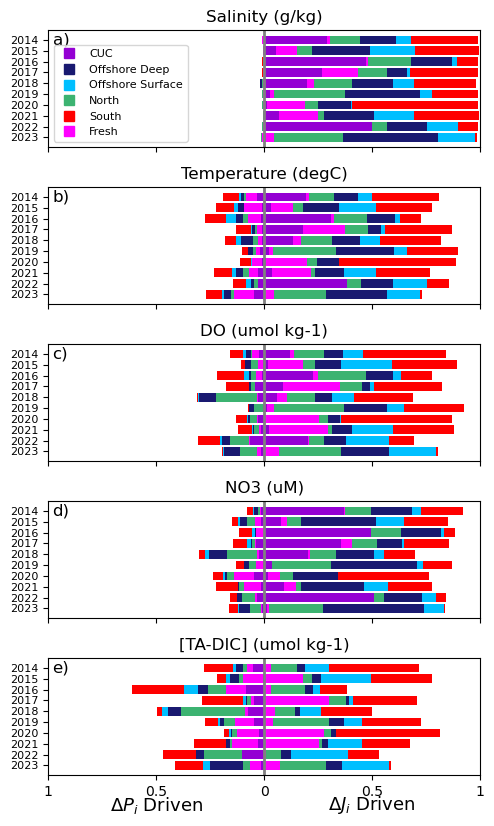

In [36]:
# without subfigures to the right
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,8])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ']][:-1],math_all15[['year','section','saltP','saltQ']][:-1],
    math_all16[['year','section','saltP','saltQ']][:-1],math_all17[['year','section','saltP','saltQ']][:-1],
    math_all18[['year','section','saltP','saltQ']][:-1],math_all19[['year','section','saltP','saltQ']][:-1],
    math_all20[['year','section','saltP','saltQ']][:-1],math_all21[['year','section','saltP','saltQ']][:-1],
    math_all22[['year','section','saltP','saltQ']][:-1],math_all23[['year','section','saltP','saltQ']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,False)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ']][:-1],math_all15[['year','section','tempP','tempQ']][:-1],
    math_all16[['year','section','tempP','tempQ']][:-1],math_all17[['year','section','tempP','tempQ']][:-1],
    math_all18[['year','section','tempP','tempQ']][:-1],math_all19[['year','section','tempP','tempQ']][:-1],
    math_all20[['year','section','tempP','tempQ']][:-1],math_all21[['year','section','tempP','tempQ']][:-1],
    math_all22[['year','section','tempP','tempQ']][:-1],math_all23[['year','section','tempP','tempQ']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,False)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ']][:-1],math_all15[['year','section','DOP','DOQ']][:-1],
    math_all16[['year','section','DOP','DOQ']][:-1],math_all17[['year','section','DOP','DOQ']][:-1],
    math_all18[['year','section','DOP','DOQ']][:-1],math_all19[['year','section','DOP','DOQ']][:-1],
    math_all20[['year','section','DOP','DOQ']][:-1],math_all21[['year','section','DOP','DOQ']][:-1],
    math_all22[['year','section','DOP','DOQ']][:-1],math_all23[['year','section','DOP','DOQ']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,False)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q']][:-1],math_all15[['year','section','NO3P','NO3Q']][:-1],
    math_all16[['year','section','NO3P','NO3Q']][:-1],math_all17[['year','section','NO3P','NO3Q']][:-1],
    math_all18[['year','section','NO3P','NO3Q']][:-1],math_all19[['year','section','NO3P','NO3Q']][:-1],
    math_all20[['year','section','NO3P','NO3Q']][:-1],math_all21[['year','section','NO3P','NO3Q']][:-1],
    math_all22[['year','section','NO3P','NO3Q']][:-1],math_all23[['year','section','NO3P','NO3Q']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7,False)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ']][:-1],math_all15[['year','section','TADICP','TADICQ']][:-1],
    math_all16[['year','section','TADICP','TADICQ']][:-1],math_all17[['year','section','TADICP','TADICQ']][:-1],
    math_all18[['year','section','TADICP','TADICQ']][:-1],math_all19[['year','section','TADICP','TADICQ']][:-1],
    math_all20[['year','section','TADICP','TADICQ']][:-1],math_all21[['year','section','TADICP','TADICQ']][:-1],
    math_all22[['year','section','TADICP','TADICQ']][:-1],math_all23[['year','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (umol kg-1)',ax9,False)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=12)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=12)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=12)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)
# fig.legend(handles=legend_handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.001), frameon=True,fontsize=9)


# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution_flux.pdf", bbox_inches='tight')

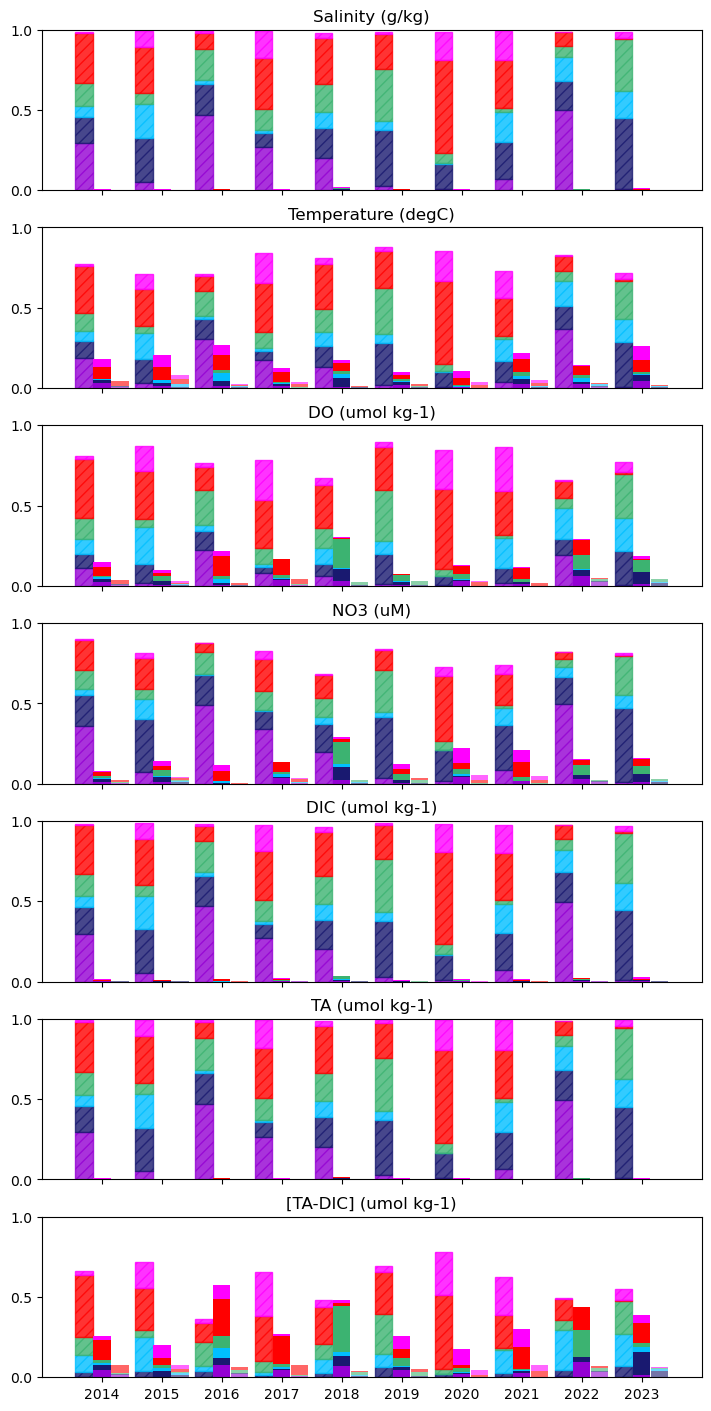

In [37]:
# With cross term
fig = plt.figure(constrained_layout=True, figsize=[7,2*7])
gs = GridSpec(7, 1, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
ax7 = fig.add_subplot(gs[6])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
three_bar(df,'Salinity (g/kg)',ax1)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
three_bar(df,'Temperature (degC)',ax2)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
three_bar(df,'DO (umol kg-1)',ax3)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1],])
three_bar(df,'NO3 (uM)',ax4)

# DIC
df = pd.concat([math_all14[['year','section','DICP','DICQ','DICX']][:-1],math_all15[['year','section','DICP','DICQ','DICX']][:-1],
    math_all16[['year','section','DICP','DICQ','DICX']][:-1],math_all17[['year','section','DICP','DICQ','DICX']][:-1],
    math_all18[['year','section','DICP','DICQ','DICX']][:-1],math_all19[['year','section','DICP','DICQ','DICX']][:-1],
    math_all20[['year','section','DICP','DICQ','DICX']][:-1],math_all21[['year','section','DICP','DICQ','DICX']][:-1],
    math_all22[['year','section','DICP','DICQ','DICX']][:-1],math_all23[['year','section','DICP','DICQ','DICX']][:-1],])
three_bar(df,'DIC (umol kg-1)',ax5)

# TA
df = pd.concat([math_all14[['year','section','TAP','TAQ','TAX']][:-1],math_all15[['year','section','TAP','TAQ','TAX']][:-1],
    math_all16[['year','section','TAP','TAQ','TAX']][:-1],math_all17[['year','section','TAP','TAQ','TAX']][:-1],
    math_all18[['year','section','TAP','TAQ','TAX']][:-1],math_all19[['year','section','TAP','TAQ','TAX']][:-1],
    math_all20[['year','section','TAP','TAQ','TAX']][:-1],math_all21[['year','section','TAP','TAQ','TAX']][:-1],
    math_all22[['year','section','TAP','TAQ','TAX']][:-1],math_all23[['year','section','TAP','TAQ','TAX']][:-1]])
three_bar(df,'TA (umol kg-1)',ax6)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
three_bar(df,'[TA-DIC] (umol kg-1)',ax7)

ax7.set_xticklabels(np.arange(2014,2024,1));

contribution of each watermass to the variability in each tracer:

In [38]:
# SALT

df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.004 (0.003), Q mean = 0.073 (0.072), X mean = 0.001 (0.001), mean total = 0.077 (0.072), std% = 92.60000000000001
off_s: P mean = 0.001 (0.001), Q mean = 0.098 (0.072), X mean = 0.0 (0.0), mean total = 0.099 (0.072), std% = 73.0
north: P mean = 0.003 (0.001), Q mean = 0.152 (0.1), X mean = 0.0 (0.0), mean total = 0.155 (0.101), std% = 65.0
off_d: P mean = 0.001 (0.002), Q mean = 0.226 (0.096), X mean = 0.0 (0.0), mean total = 0.227 (0.096), std% = 42.3
cuc: P mean = 0.001 (0.001), Q mean = 0.19 (0.177), X mean = 0.0 (0.0), mean total = 0.191 (0.177), std% = 92.9
south: P mean = 0.001 (0.001), Q mean = 0.249 (0.152), X mean = 0.0 (0.0), mean total = 0.25 (0.151), std% = 60.6
total P mean = 0.0102 (0.004), Q mean = 0.9882, (0.004)


In [39]:
# TEMP

df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.042 (0.026), Q mean = 0.075 (0.073), X mean = 0.007 (0.008), mean total = 0.124 (0.084), std% = 67.5
off_s: P mean = 0.015 (0.013), Q mean = 0.085 (0.059), X mean = 0.005 (0.005), mean total = 0.105 (0.065), std% = 62.1
north: P mean = 0.013 (0.008), Q mean = 0.119 (0.083), X mean = 0.002 (0.002), mean total = 0.134 (0.086), std% = 64.2
off_d: P mean = 0.024 (0.014), Q mean = 0.148 (0.065), X mean = 0.005 (0.003), mean total = 0.177 (0.074), std% = 41.6
cuc: P mean = 0.02 (0.012), Q mean = 0.127 (0.124), X mean = 0.003 (0.003), mean total = 0.15 (0.128), std% = 85.3
south: P mean = 0.064 (0.019), Q mean = 0.23 (0.134), X mean = 0.015 (0.011), mean total = 0.31 (0.135), std% = 43.6
total P mean = 0.1791 (0.0578), Q mean = 0.7844, (0.0615)


In [40]:
# DO

df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.012 (0.012), Q mean = 0.111 (0.102), X mean = 0.001 (0.002), mean total = 0.124 (0.1), std% = 80.30000000000001
off_s: P mean = 0.007 (0.006), Q mean = 0.113 (0.08), X mean = 0.001 (0.002), mean total = 0.121 (0.079), std% = 64.7
north: P mean = 0.052 (0.05), Q mean = 0.134 (0.098), X mean = 0.008 (0.007), mean total = 0.194 (0.12), std% = 61.9
off_d: P mean = 0.028 (0.025), Q mean = 0.109 (0.052), X mean = 0.006 (0.006), mean total = 0.143 (0.072), std% = 50.1
cuc: P mean = 0.023 (0.017), Q mean = 0.073 (0.076), X mean = 0.004 (0.007), mean total = 0.1 (0.09), std% = 90.2
south: P mean = 0.052 (0.043), Q mean = 0.254 (0.131), X mean = 0.012 (0.011), mean total = 0.318 (0.143), std% = 45.1
total P mean = 0.1735 (0.0736), Q mean = 0.7936, (0.077)


In [41]:
# NO3

df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))


fresh: P mean = 0.029 (0.029), Q mean = 0.022 (0.022), X mean = 0.007 (0.011), mean total = 0.058 (0.057), std% = 99.4
off_s: P mean = 0.008 (0.007), Q mean = 0.051 (0.04), X mean = 0.002 (0.003), mean total = 0.061 (0.04), std% = 64.7
north: P mean = 0.039 (0.036), Q mean = 0.118 (0.076), X mean = 0.006 (0.006), mean total = 0.162 (0.091), std% = 56.00000000000001
off_d: P mean = 0.024 (0.023), Q mean = 0.247 (0.106), X mean = 0.005 (0.004), mean total = 0.276 (0.117), std% = 42.4
cuc: P mean = 0.019 (0.014), Q mean = 0.211 (0.185), X mean = 0.002 (0.004), mean total = 0.232 (0.189), std% = 81.5
south: P mean = 0.044 (0.022), Q mean = 0.156 (0.106), X mean = 0.011 (0.008), mean total = 0.21 (0.117), std% = 55.400000000000006
total P mean = 0.1637 (0.0589), Q mean = 0.8039, (0.0646)


In [42]:
# TA

df = pd.concat([math_all14[['year','section','TAP','TAQ','TAX']][:-1],math_all15[['year','section','TAP','TAQ','TAX']][:-1],
    math_all16[['year','section','TAP','TAQ','TAX']][:-1],math_all17[['year','section','TAP','TAQ','TAX']][:-1],
    math_all18[['year','section','TAP','TAQ','TAX']][:-1],math_all19[['year','section','TAP','TAQ','TAX']][:-1],
    math_all20[['year','section','TAP','TAQ','TAX']][:-1],math_all21[['year','section','TAP','TAQ','TAX']][:-1],
    math_all22[['year','section','TAP','TAQ','TAX']][:-1],math_all23[['year','section','TAP','TAQ','TAX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.002 (0.001), Q mean = 0.076 (0.074), X mean = 0.0 (0.0), mean total = 0.078 (0.074), std% = 95.0
off_s: P mean = 0.0 (0.0), Q mean = 0.098 (0.072), X mean = 0.0 (0.0), mean total = 0.099 (0.072), std% = 73.1
north: P mean = 0.002 (0.001), Q mean = 0.153 (0.101), X mean = 0.0 (0.0), mean total = 0.155 (0.101), std% = 65.4
off_d: P mean = 0.001 (0.002), Q mean = 0.225 (0.097), X mean = 0.0 (0.0), mean total = 0.227 (0.096), std% = 42.4
cuc: P mean = 0.001 (0.001), Q mean = 0.189 (0.177), X mean = 0.0 (0.0), mean total = 0.191 (0.178), std% = 93.0
south: P mean = 0.001 (0.001), Q mean = 0.249 (0.152), X mean = 0.0 (0.0), mean total = 0.25 (0.152), std% = 60.6
total P mean = 0.0081 (0.0025), Q mean = 0.9906, (0.0025)


In [43]:
# DIC

df = pd.concat([math_all14[['year','section','DICP','DICQ','DICX']][:-1],math_all15[['year','section','DICP','DICQ','DICX']][:-1],
    math_all16[['year','section','DICP','DICQ','DICX']][:-1],math_all17[['year','section','DICP','DICQ','DICX']][:-1],
    math_all18[['year','section','DICP','DICQ','DICX']][:-1],math_all19[['year','section','DICP','DICQ','DICX']][:-1],
    math_all20[['year','section','DICP','DICQ','DICX']][:-1],math_all21[['year','section','DICP','DICQ','DICX']][:-1],
    math_all22[['year','section','DICP','DICQ','DICX']][:-1],math_all23[['year','section','DICP','DICQ','DICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.004 (0.003), Q mean = 0.071 (0.07), X mean = 0.001 (0.001), mean total = 0.075 (0.072), std% = 95.89999999999999
off_s: P mean = 0.001 (0.001), Q mean = 0.095 (0.07), X mean = 0.0 (0.0), mean total = 0.096 (0.07), std% = 72.7
north: P mean = 0.005 (0.005), Q mean = 0.15 (0.099), X mean = 0.001 (0.001), mean total = 0.156 (0.1), std% = 64.4
off_d: P mean = 0.003 (0.003), Q mean = 0.227 (0.097), X mean = 0.001 (0.0), mean total = 0.23 (0.098), std% = 42.699999999999996
cuc: P mean = 0.002 (0.002), Q mean = 0.191 (0.177), X mean = 0.0 (0.001), mean total = 0.193 (0.178), std% = 92.10000000000001
south: P mean = 0.004 (0.003), Q mean = 0.243 (0.15), X mean = 0.001 (0.001), mean total = 0.249 (0.149), std% = 59.8
total P mean = 0.0189 (0.0079), Q mean = 0.9777, (0.0081)


In [44]:
# TA-DIC

df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.057 (0.04), Q mean = 0.115 (0.104), X mean = 0.011 (0.014), mean total = 0.183 (0.136), std% = 74.5
off_s: P mean = 0.018 (0.017), Q mean = 0.113 (0.082), X mean = 0.004 (0.005), mean total = 0.135 (0.083), std% = 61.1
north: P mean = 0.069 (0.084), Q mean = 0.102 (0.074), X mean = 0.01 (0.009), mean total = 0.181 (0.12), std% = 66.5
off_d: P mean = 0.039 (0.039), Q mean = 0.036 (0.018), X mean = 0.008 (0.011), mean total = 0.083 (0.062), std% = 74.6
cuc: P mean = 0.044 (0.028), Q mean = 0.002 (0.002), X mean = 0.008 (0.011), mean total = 0.054 (0.039), std% = 71.7
south: P mean = 0.107 (0.066), Q mean = 0.234 (0.124), X mean = 0.022 (0.019), mean total = 0.364 (0.124), std% = 34.0
total P mean = 0.3341 (0.1232), Q mean = 0.6018, (0.1212)


In [45]:
# TA:DIC

df = pd.concat([math_all14[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],math_all15[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],
    math_all16[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],math_all17[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],
    math_all18[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],math_all19[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],
    math_all20[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],math_all21[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],
    math_all22[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1],math_all23[['year','section','TA:DICP','TA:DICQ','TA:DICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.003 (0.003), Q mean = 0.082 (0.08), X mean = 0.001 (0.001), mean total = 0.086 (0.082), std% = 95.8
off_s: P mean = 0.001 (0.001), Q mean = 0.1 (0.073), X mean = 0.0 (0.0), mean total = 0.101 (0.073), std% = 72.0
north: P mean = 0.003 (0.004), Q mean = 0.152 (0.101), X mean = 0.0 (0.0), mean total = 0.155 (0.102), std% = 65.5
off_d: P mean = 0.002 (0.002), Q mean = 0.216 (0.093), X mean = 0.0 (0.0), mean total = 0.218 (0.095), std% = 43.5
cuc: P mean = 0.002 (0.001), Q mean = 0.181 (0.171), X mean = 0.0 (0.0), mean total = 0.183 (0.172), std% = 93.89999999999999
south: P mean = 0.005 (0.003), Q mean = 0.25 (0.15), X mean = 0.001 (0.001), mean total = 0.256 (0.149), std% = 57.99999999999999
total P mean = 0.0155 (0.0057), Q mean = 0.9814, (0.0057)


In [46]:
sections = ['cuc','off_d','off_s','north','south','fresh']

/tmp/ipykernel_234224/2970348347.py:103: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.75, -0.35, '$\\Delta J_i$ Driven')

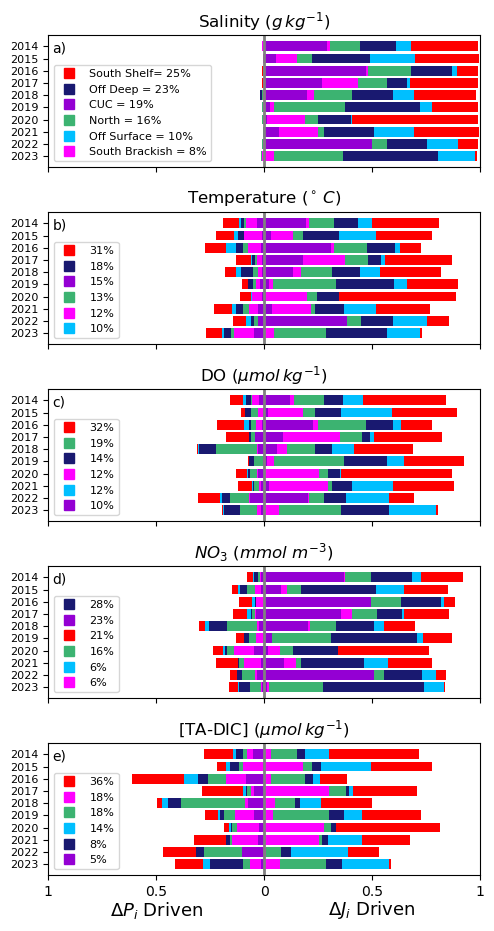

In [47]:
# with percentage contribution included in the figure 

# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,9])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,False)
ax1.set_title('Salinity ($g\,kg^{-1}$)')
   
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['South Shelf= {}%'.format(perc[4]), 'Off Deep = {}%'.format(perc[1]), 'CUC = {}%'.format(perc[0]), 'North = {}%'.format(perc[3]),
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['red','midnightblue','darkviolet','mediumseagreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,False)
ax3.set_title('Temperature ($^\circ\,C$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[1]), '{}%'.format(perc[0]),  '{}%'.format(perc[3]),
                   '{}%'.format(perc[5]),  '{}%'.format(perc[2])]
colours = ['red','midnightblue','darkviolet','mediumseagreen','magenta','deepskyblue']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax3.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,False)
ax5.set_title('DO ($\mu mol \, kg^{-1}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[1]), '{}%'.format(perc[5]),
                   '{}%'.format(perc[2]),  '{}%'.format(perc[0])]
colours = ['red','mediumseagreen','midnightblue','magenta','deepskyblue','darkviolet']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax5.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7,False)
ax7.set_title('$NO_3$ ($mmol\,\,m^{-3}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[1]), '{}%'.format(perc[0]), '{}%'.format(perc[4]),
                   '{}%'.format(perc[3]), '{}%'.format(perc[2]), '{}%'.format(perc[5])]
colours = ['midnightblue','darkviolet','red','mediumseagreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax7.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax9,False)
ax9.set_title('[TA-DIC] ($\mu mol \, kg^{-1}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[5]), '{}%'.format(perc[3]), '{}%'.format(perc[2]),
                   '{}%'.format(perc[1]),  '{}%'.format(perc[0])]
colours = ['red','magenta','mediumseagreen','deepskyblue','midnightblue','darkviolet']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax9.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=10)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=10)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=10)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=10)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=10)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta J_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)


# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution_flux.pdf", bbox_inches='tight')

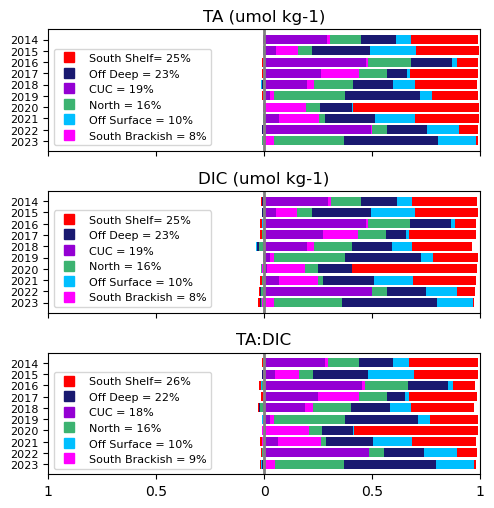

In [48]:
# TA:DIC
fig,ax=plt.subplots(3,1,figsize=[5,5])
df = pd.concat([math_all14[['year','section','TAP','TAQ']][:-1],math_all15[['year','section','TAP','TAQ']][:-1],
    math_all16[['year','section','TAP','TAQ']][:-1],math_all17[['year','section','TAP','TAQ']][:-1],
    math_all18[['year','section','TAP','TAQ']][:-1],math_all19[['year','section','TAP','TAQ']][:-1],
    math_all20[['year','section','TAP','TAQ']][:-1],math_all21[['year','section','TAP','TAQ']][:-1],
    math_all22[['year','section','TAP','TAQ']][:-1],math_all23[['year','section','TAP','TAQ']][:-1]])
combined_stacked_bar(df,'TA (umol kg-1)',ax[0],False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['South Shelf= {}%'.format(perc[4]), 'Off Deep = {}%'.format(perc[1]), 'CUC = {}%'.format(perc[0]), 'North = {}%'.format(perc[3]),
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['red','midnightblue','darkviolet','mediumseagreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

df = pd.concat([math_all14[['year','section','DICP','DICQ']][:-1],math_all15[['year','section','DICP','DICQ']][:-1],
    math_all16[['year','section','DICP','DICQ']][:-1],math_all17[['year','section','DICP','DICQ']][:-1],
    math_all18[['year','section','DICP','DICQ']][:-1],math_all19[['year','section','DICP','DICQ']][:-1],
    math_all20[['year','section','DICP','DICQ']][:-1],math_all21[['year','section','DICP','DICQ']][:-1],
    math_all22[['year','section','DICP','DICQ']][:-1],math_all23[['year','section','DICP','DICQ']][:-1]])
combined_stacked_bar(df,'DIC (umol kg-1)',ax[1],False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['South Shelf= {}%'.format(perc[4]), 'Off Deep = {}%'.format(perc[1]), 'CUC = {}%'.format(perc[0]), 'North = {}%'.format(perc[3]),
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['red','midnightblue','darkviolet','mediumseagreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax[1].legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

df = pd.concat([math_all14[['year','section','TA:DICP','TA:DICQ']][:-1],math_all15[['year','section','TA:DICP','TA:DICQ']][:-1],
    math_all16[['year','section','TA:DICP','TA:DICQ']][:-1],math_all17[['year','section','TA:DICP','TA:DICQ']][:-1],
    math_all18[['year','section','TA:DICP','TA:DICQ']][:-1],math_all19[['year','section','TA:DICP','TA:DICQ']][:-1],
    math_all20[['year','section','TA:DICP','TA:DICQ']][:-1],math_all21[['year','section','TA:DICP','TA:DICQ']][:-1],
    math_all22[['year','section','TA:DICP','TA:DICQ']][:-1],math_all23[['year','section','TA:DICP','TA:DICQ']][:-1]])
combined_stacked_bar(df,'TA:DIC',ax[2],False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['South Shelf= {}%'.format(perc[4]), 'Off Deep = {}%'.format(perc[1]), 'CUC = {}%'.format(perc[0]), 'North = {}%'.format(perc[3]),
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['red','midnightblue','darkviolet','mediumseagreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax[2].legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

ax[2].set_xticklabels([1,0.5,0,0.5,1]);

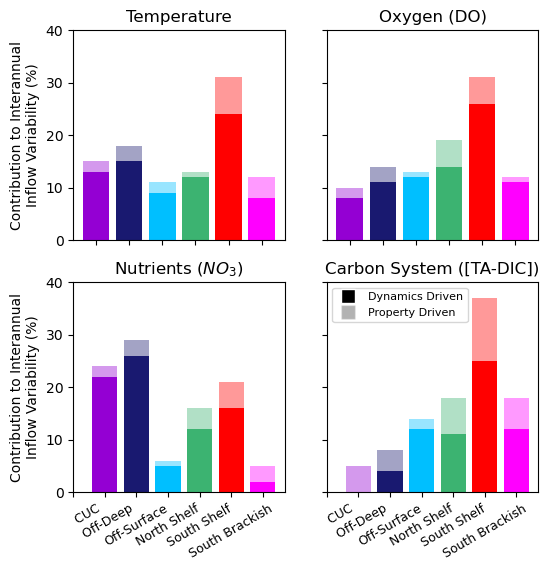

In [49]:
# for key figure

sections = ['cuc', 'off_d', 'off_s', 'north', 'south', 'fresh']
colours = ['darkviolet', 'midnightblue','deepskyblue','mediumseagreen','red','magenta']

fig, ax = plt.subplots(2,2,figsize=(6,6))

# temperature 
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[0,0].bar(range(len(sections)),percQ,color=colours)
ax[0,0].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[0,0].set_xticks(range(len(sections)))
ax[0,0].set_xticklabels([])
ax[0,0].set_yticks(np.arange(0,41,10))
ax[0,0].set_title("Temperature")


# DO 
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[0,1].bar(range(len(sections)),percQ,color=colours)
ax[0,1].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[0,1].set_xticks(range(len(sections)))
ax[0,1].set_xticklabels([])
ax[0,1].set_yticks(np.arange(0,41,10))
ax[0,1].set_yticklabels([])
ax[0,1].set_title("Oxygen (DO)")


# NO3 
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[1,0].bar(range(len(sections)),percQ,color=colours)
ax[1,0].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[1,0].set_xticks(np.array(range(len(sections)+1))-1)
ax[1,0].set_xticklabels(['        CUC','  Off-Deep','Off-Surface','North Shelf','South Shelf','South Brackish',''],rotation=30,fontsize=9)
ax[1,0].set_yticks(np.arange(0,41,10))
ax[1,0].set_title("Nutrients ($NO_3$)")


# TADIC 
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
percQ = [int(np.round(np.mean(df.normQ[df.section==region],axis=0),2)*100) for region in sections]
percP = [int(np.round(np.mean(df.normP[df.section==region],axis=0),2)*100) for region in sections]

ax[1,1].bar(range(len(sections)),percQ,color=colours)
ax[1,1].bar(range(len(sections)),percP,color=colours,bottom=percQ,alpha=0.4)
ax[1,1].set_xticks(np.array(range(len(sections)+1))-1)
ax[1,1].set_xticklabels(['        CUC','  Off-Deep','Off-Surface','North Shelf','South Shelf','South Brackish',''],rotation=30,fontsize=9)
ax[1,1].set_yticks(np.arange(0,41,10))
ax[1,1].set_yticklabels([])
ax[1,1].set_title("Carbon System ([TA-DIC])")



# formatting for all
ymax = 40
ax[0,0].set_ylim([0,ymax])
ax[0,1].set_ylim([0,ymax])
ax[1,0].set_ylim([0,ymax])
ax[1,1].set_ylim([0,ymax])

ax[0,0].set_ylabel('Contribution to Interannual\nInflow Variability (%)')
ax[1,0].set_ylabel('Contribution to Interannual\nInflow Variability (%)')


# add legend
legend_handles = []
alphas = [1,0.3]
labels = ['Dynamics Driven','Property Driven']
for i in range(len(alphas)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=10,
                          markeredgecolor='w', markerfacecolor='k',
                          label=labels[i],alpha=alphas[i]))
ax[1,1].legend(handles=legend_handles, loc='best', ncol=1, frameon=True,fontsize=8)

# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/keyfigurebars.jpg", bbox_inches='tight')